In [1]:
import keras
from keras import backend as K
import numpy as np
import io
import base64
from IPython.display import HTML
#import skvideo
#skvideo.setFFmpegPath("/usr/local/bin")
import skvideo.io
import cv2
import json
import matplotlib.pyplot as plt
import functools
import copy

from keras.models import Sequential, model_from_json
from keras.layers.core import Dense, Dropout, Flatten
from keras.optimizers import sgd, Adam
from keras.layers import Conv2D, MaxPooling2D, Activation, AveragePooling2D,Reshape,BatchNormalization

Using TensorFlow backend.


# Project on Deep Reinforcement Learning and environment modifications

__Notations__: $E_p$ is the expectation under probability $p$.

# Context

## The environment, the agent and the game

### The environment

```Environment``` is an abstract class that represents the states, rewards, and actions to obtain the new state.

The method ```act``` allows to act on the environment at a given state $s_t$ (stored internally), via action $a_t$. The method will return the new state $s_{t+1}$, the reward $r(s_{t},a_{t})$ and determines if $t\leq T$ (*game_over*).

The method ```reset``` simply reinitializes the environment to a random state $s_0$.

The method ```draw``` displays the current state $s_t$ (this is useful to check the behavior of the Agent).

We modelize $s_t$ as a tensor, while $a_t$ is an integer.

### The Agent

The goal of the ```Agent``` is to interact with the ```Environment``` by proposing actions $a_t$ obtained from a given state $s_t$ to attempt to maximize its __reward__ $r(s_t,a_t)$. We propose the following abstract class:

In [2]:
class Agent(object):
    def __init__(self, epsilon=0.1, n_action=4):
        self.epsilon = epsilon
        self.n_action = n_action
        self.vis = 2
        self.t = 0
    
    def set_epsilon(self,e):
        self.epsilon = e

    def act(self,s,train=True):
        """ This function should return the next action to do:
        an integer between 0 and 4 (not included) with a random exploration of epsilon"""
        self.t += 1
        if train:
            if np.random.rand() <= self.epsilon:
                a = np.random.randint(0, self.n_action, size=1)[0]
            else:
                a = self.learned_act(s)
        else: # in some cases, this can improve the performance.. remove it if poor performances
            a = self.learned_act(s)

        return a

    def learned_act(self,s):
        """ Act via the policy of the agent, from a given state s
        it proposes an action a"""
        pass

    def reinforce(self, s, n_s, a, r, game_over_):
        """ This function is the core of the learning algorithm. 
        It takes as an input the current state s_, the next state n_s_
        the action a_ used to move from s_ to n_s_ and the reward r_.
        
        Its goal is to learn a policy.
        """
        pass

    def save(self):
        """ This function returns basic stats if applicable: the
        loss and/or the model"""
        pass

    def load(self):
        """ This function allows to restore a model"""
        pass

---
# The game, *eat cheese*

A rat runs on an island and tries to eat as much as possible. The island is subdivided into $N\times N$ cells, in which there are cheese (+0.5) and poisonous cells (-1). The rat has a visibility of 2 cells (thus it can see $5^2$ cells). The rat is given a time $T$ to accumulate as much food as possible. It can perform 4 actions: going up, down, left, right. 

The goal is to code an agent to solve this task that will learn by trial and error. We propose the following environment:

In [3]:
class Environment(object):
    def __init__(self, grid_size=19, max_time=200, temperature=0.3, immob_penalty=0):
        grid_size = grid_size + 8
        self.grid_size = grid_size
        self.max_time = max_time
        self.temperature = temperature 
        self.immob_penalty = immob_penalty
        self.vis = 2
        # this will impact the number of positive and negative rewards in the environment

        # board on which one plays
        self.board = np.zeros((grid_size,grid_size)) # possible reward in each location on the board
        self.position = np.zeros((grid_size,grid_size)) # the very position of the rat at time t
        self.malus_position = np.zeros((self.grid_size, self.grid_size)) # recording malus rewards on visited locations
        
        # coordinate of the rat
        self.x = 0
        self.y = 1

        # self time
        self.t = 0

        self.scale = 16

        self.to_draw = np.zeros((max_time+2, grid_size*self.scale, grid_size*self.scale, 3))
        

    def draw(self,e):
        skvideo.io.vwrite('runs/' + str(e) + '.mp4', self.to_draw)

    def get_frame(self,t):
        b = np.zeros((self.grid_size,self.grid_size,3))+128
        b[self.board==0.5, 0] = 256 # Red for cheese
        b[self.board>0.5, 1] = 256 # Green for the big reward
        b[self.board<0, 2] = 256 # Blue for poison
        b[self.x,self.y,:] = 256
        b[-4:,:,:]=0
        b[:,-4:,:]=0
        b[:4,:,:]=0
        b[:,:4,:]=0
        
        b = cv2.resize(b, None, fx=self.scale, fy=self.scale, interpolation=cv2.INTER_NEAREST)

        self.to_draw[t,:,:,:] = b
        
        
    def act(self, action, train=True):
        """This function returns the new state, reward and decides if the
        game ends."""

        self.get_frame(int(self.t))

        self.position = np.zeros((self.grid_size, self.grid_size))

        self.position[0:4, :] = -1
        self.position[:, 0:4] = -1
        self.position[-4:, :] = -1
        self.position[:, -4:] = -1

        self.position[self.x, self.y] = 1
        if action == 0:
            if self.x == self.grid_size-5:
                self.x = self.x - 1
            else:
                self.x = self.x + 1
        elif action == 1:
            if self.x == 4:
                self.x = self.x + 1
            else:
                self.x = self.x - 1
        elif action == 2:
            if self.y == self.grid_size - 5:
                self.y = self.y - 1
            else:
                self.y = self.y + 1
        elif action == 3:
            if self.y == 4:
                self.y = self.y + 1
            else:
                self.y = self.y - 1
        else:
            RuntimeError('Error: action not recognized')

        self.t = self.t + 1
        
        ### Then before giving the reward, we give the environment the possibility to change and act differently
        self.modify_board() # Everything needed can be found in self.x, self.y, self.board, self.t, etc...
        
        reward = 0
        if train:
            reward += self.malus_position[self.x, self.y]
            
        self.malus_position[self.x, self.y] = - self.immob_penalty
        
        reward += self.board[self.x, self.y]
        
        self.board[self.x, self.y] = 0
        game_over = self.t > self.max_time
        state = np.concatenate((self.malus_position.reshape(self.grid_size, self.grid_size,1),
                                self.board.reshape(self.grid_size, self.grid_size,1),
                                self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)
        state = state[(self.x-self.vis):(self.x+1+self.vis),(self.y-self.vis):(self.y+1+self.vis),:]

        state_troncated = np.zeros((9,9,state.shape[2]))
        if self.vis == 4 :
            state_troncated = state
        else:
            state_troncated[(4-self.vis):(self.vis-4),(4-self.vis):(self.vis-4),:]=state
        
        return state_troncated, reward, game_over

    def reset(self):
        """This function resets the game and returns the initial state"""
        self.vis = 2
        self.x = np.random.randint(5, self.grid_size-5, size=1)[0]
        self.y = np.random.randint(5, self.grid_size-5, size=1)[0]

        self.malus_position = np.zeros((self.grid_size, self.grid_size))
        
        island_size = self.grid_size - 8
        grid_bonus = 0.5*np.random.binomial(1, self.temperature, size=island_size**2)
        grid_bonus = grid_bonus.reshape(island_size, island_size)
        bonus = np.zeros((self.grid_size, self.grid_size))
        bonus[4:-4,4:-4] = grid_bonus

        grid_malus = -1.0*np.random.binomial(1, self.temperature, size=island_size**2)
        grid_malus = grid_malus.reshape(island_size, island_size)
        malus = np.zeros((self.grid_size, self.grid_size))
        malus[4:-4,4:-4] = grid_malus

        self.to_draw = np.zeros((self.max_time+2, self.grid_size*self.scale, self.grid_size*self.scale, 3))


        malus[bonus>0] = 0

        self.board = bonus + malus

        self.position = np.zeros((self.grid_size, self.grid_size))
        self.position[:4, :] = -1
        self.position[:, :4] = -1
        self.position[-4:,:] = -1
        self.position[:,-4:] = -1
        self.board[self.x,self.y] = 0 # since we assume that we don't consider the first state in the reward,
        self.malus_position[self.x, self.y] = - self.immob_penalty # we can consider the original position as visited (or not ?)
        self.t = 0

        state = np.concatenate((self.malus_position.reshape(self.grid_size, self.grid_size,1),
                                self.board.reshape(self.grid_size, self.grid_size,1),
                                self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)

        state = state[self.x - 2:self.x + 3, self.y - 2:self.y + 3, :]
        
        state_troncated = np.zeros((9,9,state.shape[2]))
        if self.vis == 4 :
            state_troncated = state
        else:
            state_troncated[(4-self.vis):(self.vis-4),(4-self.vis):(self.vis-4),:]=state
       
        return state_troncated
    
    def modify_board(self):
        """This function modifies the board itself. It should use self.t and self.board"""
        pass
    
    def modify_visibility(self, win, lose):
        """This function modifies the visibility of the Agent. It should use self.vis"""
        pass
    
    def add_big_reward(self, win):
        """This function modifies the visibility of the Agent. It should use self.vis"""
        pass

Let's define now the hyper parameters :

In [4]:
# parameters
size = 19
T = 500
temperature = 0.3
epochs_train = 10 # set small when debugging
epochs_test = 10 # set small when debugging

# display videos
def display_videos(name):
    video = io.open('runs/'+name, 'r+b').read()
    encoded = base64.b64encode(video)
    return '''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))

Let's now define the training loop and the test loop :

In [5]:
def train(agent, env,epoch, eps_decay=None, eps_step=None, freq_video=10, memory_access='random', prefix=''):
    # Number of won games
    score = 0
    score_record=[]
    loss = 0
    
    name = prefix
    name = name + '_explore_' if eps_step and eps_decay else name
    
    eps = agent.epsilon

    for e in range(epoch):
        
        if eps_step and eps_decay and e!=0 and e%eps_step==0:
            eps = eps*eps_decay
            agent.set_epsilon(eps)
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        agent.t=0
        # This assumes that the games will terminate
        game_over = False
        
        win = 0
        lose = 0

        while not game_over:
            # The agent performs an action
            action = agent.act(state)
            
            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state
            
            state, reward, game_over = env.act(action, train=True)
            
            # Update the counters
            # We modify this interval because we only care about the true reward 
            # and not the penalty of coming back to visited places. This penalty aims at helping the algorithm
            # itself but shouldn't be considered in the win/lose counts
            win_before = win
            if reward > 0:
                win += reward
            elif reward != -env.immob_penalty:
                lose -= reward
            
            # Apply the reinforcement strategy
            loss = agent.reinforce(prev_state, state, action, reward, game_over, memory_access=memory_access)
            
            env.modify_visibility(win, lose)
            
            if win_before < win :
                env.add_big_reward(win)
            
            agent.vis = env.vis
            
        # Save as a mp4
        if (e+1) % freq_video == 0:
            env.draw(name+str(e+1))

        # Update stats
        score += win-lose
        
        win_max = np.sum(np.where(env.to_draw[0, ::env.scale, ::env.scale, 0]==256, .5, 0)) - 1 # don't consider
        lose_max = np.sum(np.where(env.to_draw[0, ::env.scale, ::env.scale, 2]==256, 1.0, 0)) - 1 # the rat

        print("Epoch {0:03d}/{1:03d} | Loss {2:.4f} | Win/lose count {3}({4:.1f}%)/{5}({6:.1f}%) ({7:.1f})"
              .format(e+1, epoch, loss, win, 100*win/win_max, lose, 100*lose/lose_max, win-lose))
        agent.save(name_weights=name+'_model.h5', name_model=name+'_model.json')
        
        score_record.append(score)
        
    return score_record
        
        
#------------------------------------------------------------------------------------------------

def test(agent,env,epochs,prefix=''):
    # Number of won games
    score = 0
        
    for e in range(1,epochs+1):
        # At each epoch, we restart to a fresh game and get the initial state
        
        state = env.reset()
        
        # This assumes that the games will end
        game_over = False

        win = 0
        lose = 0

        while not game_over:
            # The agent performs an action
            action = agent.act(state)

            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state
            state, reward, game_over = env.act(action)

            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < -0.1:
                lose = lose - reward

        # Save as a mp4
        env.draw(prefix+str(e))

        # Update stats
        score = score + win-lose
        
        win_max = np.sum(np.where(env.to_draw[0, ::env.scale, ::env.scale, 0]==256, .5, 0)) - 1
        lose_max = np.sum(np.where(env.to_draw[0, ::env.scale, ::env.scale, 2]==256, 1.0, 0)) - 1

        print("Win/lose count {}({:.1f}%)/{}({:.1f}%). Average score ({:.1f})"
              .format(win, 100*win/win_max, lose, 100*lose/lose_max, score/e))
    print('Final score: '+str(score/epochs))

## Random Agent

In [6]:
class RandomAgent(Agent):
    def __init__(self):
        super(RandomAgent, self).__init__()

    def learned_act(self, s):
        return np.random.randint(4)

Let's try it out ! *NB : This random agent cannot be trained so we test it directly*

In [41]:
# Initialize the game
env = Environment(grid_size=size, max_time=T, temperature=temperature)

# Initialize the agent!
agent = RandomAgent()

test(agent, env, epochs_test, prefix='random')
HTML(display_videos('random1.mp4'))

Win/lose count 18.0(17.1%)/30.0(37.5%). Average score (-12.0)
Win/lose count 19.5(18.2%)/33.0(46.5%). Average score (-12.8)
Win/lose count 18.0(16.1%)/29.0(39.7%). Average score (-12.2)
Win/lose count 19.0(17.9%)/33.0(44.0%). Average score (-12.6)
Win/lose count 20.0(20.8%)/39.0(43.3%). Average score (-13.9)
Win/lose count 22.0(19.8%)/28.0(39.4%). Average score (-12.6)
Win/lose count 20.5(17.4%)/36.0(39.6%). Average score (-13.0)
Win/lose count 18.5(18.3%)/36.0(39.6%). Average score (-13.6)
Win/lose count 22.0(21.2%)/42.0(47.7%). Average score (-14.3)
Win/lose count 19.5(18.2%)/27.0(37.5%). Average score (-13.6)
Final score: -13.6


> A random agent is not great and performs really badly... Let's head to a more suitable approach when actually learning something by reinforcement. However, this agent will be useful to draw comparisons when modifying the environment.

***
## DQN

***
The DQN-learning algorithm relies on these derivations to train the parameters $\theta$ of a Deep Neural Network:

1. At the state $s_t$, select the action $a_t$ with best reward using $Q_t$ and store the results;

2. Obtain the new state $s_{t+1}$ from the environment $p$;

3. Store $(s_t,a_t,s_{t+1})$;

4. Obtain $Q_{t+1}$ by minimizing  $\mathcal{L}$ from a recovered batch from the previously stored results.

***
We will need a class ```Memory``` that stores moves (in a replay buffer) via ```remember``` and provides a ```random_access``` to these. A maximum memory size is required to avoid side effects.

In [7]:
class Memory(object):
    def __init__(self, max_memory=100):
        self.max_memory = max_memory
        self.memory = list()

    def remember(self, m):
        self.memory.append(m)
        if len(self.memory)>100:
            self.memory = self.memory[-100:]

    def access(self, memory_index):
        return self.memory[memory_index]

In [8]:
class DQN(Agent):
    def __init__(self, epsilon = 0.1, memory_size=100, batch_size = 16, n_state=3):
        super(DQN, self).__init__(epsilon = epsilon)

        # Discount for Q learning
        self.discount = 0.8 # previous : 0.99
        
        # number of state
        self.n_state = n_state

        # Memory
        self.memory = Memory(memory_size)
        
        # Batch size when learning
        self.batch_size = batch_size
        
    def learned_act(self, s):
        pred_rwd_per_action = self.model.predict(s.reshape(1,9,9,self.n_state))
        return np.argmax(pred_rwd_per_action)

    def reinforce(self, s_, n_s_, a_, r_, game_over_, memory_access='random'):
        # Two steps: first memorize the states, second learn from the pool
            
        self.memory.remember([s_, n_s_, a_, r_, game_over_])
        
        input_states = np.zeros((self.batch_size, 9, 9, self.n_state))
        target_q = np.zeros((self.batch_size, 4))
        
        memory_index = np.random.randint(len(self.memory.memory) - self.batch_size) if len(self.memory.memory)-self.batch_size>0 else 0
        for i in range(self.batch_size):
            if memory_access=='random':
                memory_index = np.random.randint(len(self.memory.memory))
            else:
                memory_index += i
            sample = self.memory.access(memory_index%len(self.memory.memory))
            
            input_states[i,:,:,:] = sample[0]
            
            target_q[i, sample[2]] = sample[3]
            
            if not game_over_:
                target_q[i, sample[2]] += self.discount*np.max(self.model.predict(sample[1].reshape(1,9,9,self.n_state)).flatten())
        
        target_q = np.clip(target_q, -30, 30)

        l = self.model.train_on_batch(input_states, target_q)

        return l

    def save(self, name_weights='model.h5', name_model='model.json'):
        self.model.save_weights('runs/'+name_weights, overwrite=True)
        with open('runs/'+name_model, "w") as outfile:
            json.dump(self.model.to_json(), outfile)
            
    def load(self,name_weights='model.h5',name_model='model.json'):
        with open('runs/'+name_model, "r") as jfile:
            model = model_from_json(json.load(jfile))
        model.load_weights('runs/'+name_weights)
        model.compile("sgd", "mse")
        self.model = model


def my_custom_loss(y_true,y_pred):
    """
    Let's have a look at the issue when using the MSE loss. Take for example the situation in which :
       - Target = [   0, 0.8,    0,   0]
       - Output = [-0.3, 0.1, -1.5, 4.1]
    Then the MSE loss will also consider the distance between 0 and the conrresponding output value even though
    0 means that we don't have the information since the action wasn't considered. Thus the algorithm is mislead
    with a wrong information and it actually learns either to reproduce it's output, or to only output values
    close to 0.
    
    What could be much more meaningful would be to only consider the squared deviation between the target and
    the output but only for the information that we have.
    """
    norm = K.sum(y_true, axis=-1)+1e-6 # Get the value of the non-zero element from the target
    norm = K.reshape(norm, shape=(-1,1)) # Reshape it in order to concatenate it after
    norm = K.concatenate([norm, norm, norm, norm],axis=-1) # Concatenate in order to allow the next operation
    loss = K.sum(K.square(y_true * (y_true - y_pred) / norm), axis=-1) # Multiply the deviation by the target
    # thus the non selected actions won't be considered in the loss (and divide by the norm of the target not 
    # to impact the final loss)
    return loss

class DQN_FC(DQN):
    def __init__(self, *args, lr=0.1,**kwargs):
        super(DQN_FC, self).__init__(*args,**kwargs)
        
        # NN Model
        
        model = Sequential()
        model.add(Flatten())
        model.add(Dense(32))
        model.add(Dense(64))
        model.add(Dense(4))
        
        loss = my_custom_loss #"mse"
        optimizer = Adam(lr=lr) #sgd(lr=lr, decay=1e-4, momentum=0.0), loss="mse")
        
        model.compile(optimizer=optimizer, loss=loss)
        self.model = model
        

In [44]:
K.clear_session()
env = Environment(grid_size=size, max_time=T, temperature=0.3)
agent = DQN_FC(lr=.0001, epsilon = 0.3, memory_size=2000, batch_size = 64)
train(agent, env, epoch=20, prefix='fc_train')
HTML(display_videos('fc_train20.mp4'))

# we get impressively good results ! 
# It could be interesting to select the best set of parameters with a grid search

Epoch 001/020 | Loss 0.0009 | Win/lose count 25.5(44.7%)/25.0(37.9%) (0.5)
Epoch 002/020 | Loss 0.0141 | Win/lose count 26.0(43.7%)/19.0(21.8%) (7.0)
Epoch 003/020 | Loss 0.0087 | Win/lose count 25.5(57.3%)/17.0(20.2%) (8.5)
Epoch 004/020 | Loss 0.0085 | Win/lose count 30.5(56.0%)/16.0(18.6%) (14.5)
Epoch 005/020 | Loss 0.1041 | Win/lose count 29.0(50.9%)/12.0(17.4%) (17.0)
Epoch 006/020 | Loss 0.0000 | Win/lose count 34.5(57.5%)/15.0(21.1%) (19.5)
Epoch 007/020 | Loss 0.0999 | Win/lose count 41.5(74.8%)/13.0(18.1%) (28.5)
Epoch 008/020 | Loss 0.0027 | Win/lose count 30.0(78.9%)/11.0(15.9%) (19.0)
Epoch 009/020 | Loss 0.0002 | Win/lose count 30.5(57.5%)/17.0(20.5%) (13.5)
Epoch 010/020 | Loss 0.0123 | Win/lose count 31.5(66.3%)/17.0(21.5%) (14.5)
Epoch 011/020 | Loss 0.0047 | Win/lose count 34.5(60.5%)/7.0(10.6%) (27.5)
Epoch 012/020 | Loss 0.0000 | Win/lose count 21.5(37.7%)/8.0(10.3%) (13.5)
Epoch 013/020 | Loss 0.0087 | Win/lose count 35.5(64.5%)/12.0(15.4%) (23.5)
Epoch 014/020 | L

***
What if we were using a CNN instead ?

In [9]:
class DQN_CNN(DQN):
    def __init__(self, *args,lr=0.1,**kwargs):
        super(DQN_CNN, self).__init__(*args,**kwargs)
        
        model = Sequential()
        model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
        model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
        model.add(Flatten())
        model.add(Dense(16))
        model.add(Dense(4))
        
        loss = my_custom_loss #"mse"
        optimizer = Adam(lr=lr) #sgd(lr=lr, decay=1e-4, momentum=0.0), loss="mse")
        
        model.compile(optimizer=optimizer, loss=loss)
        self.model = model

In [46]:
K.clear_session()
env = Environment(grid_size=size, max_time=T, temperature=0.3)
agent = DQN_CNN(lr=.001, epsilon = 0.2, memory_size=2000, batch_size = 64)
train(agent, env, epoch=20, prefix='cnn_train')
HTML(display_videos('cnn_train20.mp4'))

### Comments :
# The loss represents the learning of the algorithm and the win/lose count represents somehow how well does the
# algorithm generalizes.

Epoch 001/020 | Loss 0.0174 | Win/lose count 12.5(24.8%)/18.0(21.2%) (-5.5)
Epoch 002/020 | Loss 0.1730 | Win/lose count 35.5(70.3%)/19.0(23.2%) (16.5)
Epoch 003/020 | Loss 0.0373 | Win/lose count 39.0(69.6%)/10.0(13.3%) (29.0)
Epoch 004/020 | Loss 0.0303 | Win/lose count 42.5(70.8%)/15.0(23.1%) (27.5)
Epoch 005/020 | Loss 0.0006 | Win/lose count 42.0(84.0%)/14.0(18.7%) (28.0)
Epoch 006/020 | Loss 0.1842 | Win/lose count 47.0(80.3%)/15.0(23.1%) (32.0)
Epoch 007/020 | Loss 0.0071 | Win/lose count 48.0(88.9%)/15.0(21.1%) (33.0)
Epoch 008/020 | Loss 0.0001 | Win/lose count 35.5(65.7%)/12.0(15.4%) (23.5)
Epoch 009/020 | Loss 0.1061 | Win/lose count 40.0(73.4%)/14.0(20.0%) (26.0)
Epoch 010/020 | Loss 0.5253 | Win/lose count 43.0(81.9%)/9.0(15.0%) (34.0)
Epoch 011/020 | Loss 0.0059 | Win/lose count 45.5(82.0%)/21.0(26.2%) (24.5)
Epoch 012/020 | Loss 0.0304 | Win/lose count 44.5(85.6%)/13.0(17.1%) (31.5)
Epoch 013/020 | Loss 0.0000 | Win/lose count 53.0(83.5%)/10.0(15.2%) (43.0)
Epoch 014/020

CNN seems to perform better that FC, but we see that they both struggle to find new cheese at some point... Exploration seems to be a limitation of our approach...

***
***
Compare both algorithms' performances :

In [47]:
K.clear_session()
env = Environment(grid_size=size, max_time=T,temperature=0.3)
agent_cnn = DQN_CNN(lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32)
agent_cnn.load(name_weights='cnn_train_model.h5', name_model='cnn_train_model.json')

agent_fc = DQN_FC(lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32)
agent_fc.load(name_weights='fc_train_model.h5', name_model='fc_train_model.json')
print('Test of the CNN')
test(agent_cnn, env, epochs_test, prefix='cnn_test')
print('Test of the FC')
test(agent_fc, env, epochs_test, prefix='fc_test')

Test of the CNN
Win/lose count 20.0(20.6%)/6.0(7.1%). Average score (14.0)
Win/lose count 34.5(34.5%)/10.0(11.5%). Average score (19.2)
Win/lose count 24.5(21.9%)/9.0(11.2%). Average score (18.0)
Win/lose count 43.0(37.7%)/8.0(11.8%). Average score (22.2)
Win/lose count 45.5(42.9%)/11.0(15.7%). Average score (24.7)
Win/lose count 30.5(28.2%)/5.0(8.1%). Average score (24.8)
Win/lose count 39.0(35.8%)/11.0(13.8%). Average score (25.3)
Win/lose count 17.5(16.4%)/8.0(12.7%). Average score (23.3)
Win/lose count 45.0(40.2%)/8.0(10.4%). Average score (24.8)
Win/lose count 29.5(26.1%)/7.0(9.5%). Average score (24.6)
Final score: 24.6
Test of the FC
Win/lose count 13.5(12.4%)/0(0.0%). Average score (13.5)
Win/lose count 31.0(29.2%)/2.0(3.0%). Average score (21.2)
Win/lose count 27.5(24.6%)/4.0(5.9%). Average score (22.0)
Win/lose count 18.5(17.8%)/1.0(1.3%). Average score (20.9)
Win/lose count 21.5(17.6%)/6.0(7.3%). Average score (19.8)
Win/lose count 18.0(16.2%)/5.0(6.9%). Average score (18.7)

In [48]:
HTML(display_videos('cnn_test10.mp4'))

In [49]:
HTML(display_videos('fc_test10.mp4'))

> The local loss we introduced overcomes the issues related to the MSE one. In fact this is questionable since the MSE tends to make the network reproduce what it has done and penalizes bad moves (0 is better than negative rewards), but in our case, if we give a good exploration parameter we authorize the model to perform badly at first in order to get some cases to be able to predict future rewards. Once it has learned how to predict future rewards, it is thought to behave well but then would it get that bad rewards are worse than 0 ? This is questionable. In our case at least, it seems to work impressively well in very few epochs !!

***
The algorithm tends to not explore the map which can be an issue. We propose two ideas in order to encourage exploration:
1. Incorporating a decreasing $\epsilon$-greedy exploration. We use the method ```set_epsilon```
2. Append via the environment a new state that describes if a cell has been visited or not
---

In [50]:
# Training
K.clear_session()
env_eplore = Environment(grid_size=size, max_time=T, temperature=0.3, immob_penalty=0.1)
agent = DQN_CNN(lr=.001, epsilon=0.3, memory_size=2000, batch_size=32, n_state=3)
train(agent, env, epoch=20, eps_decay=0.5, eps_step=3, prefix='cnn_train')
HTML(display_videos('cnn_train_explore_20.mp4'))

Epoch 001/020 | Loss 0.0055 | Win/lose count 38.5(65.3%)/28.0(44.4%) (10.5)
Epoch 002/020 | Loss 0.0004 | Win/lose count 32.5(65.7%)/21.0(20.2%) (11.5)
Epoch 003/020 | Loss 0.2368 | Win/lose count 52.0(86.7%)/21.0(28.0%) (31.0)
Epoch 004/020 | Loss 0.0238 | Win/lose count 48.0(90.6%)/13.0(16.5%) (35.0)
Epoch 005/020 | Loss 0.3019 | Win/lose count 54.0(83.1%)/10.0(16.4%) (44.0)
Epoch 006/020 | Loss 0.0000 | Win/lose count 47.0(87.0%)/13.0(15.7%) (34.0)
Epoch 007/020 | Loss 0.2348 | Win/lose count 55.0(88.7%)/7.0(10.0%) (48.0)
Epoch 008/020 | Loss 0.0029 | Win/lose count 51.0(93.6%)/8.0(11.4%) (43.0)
Epoch 009/020 | Loss 0.2061 | Win/lose count 51.5(91.2%)/8.0(10.7%) (43.5)
Epoch 010/020 | Loss 0.0276 | Win/lose count 51.0(84.3%)/6.0(8.2%) (45.0)
Epoch 011/020 | Loss 0.0001 | Win/lose count 42.5(70.8%)/7.0(9.2%) (35.5)
Epoch 012/020 | Loss 0.0000 | Win/lose count 30.0(59.4%)/8.0(9.2%) (22.0)
Epoch 013/020 | Loss 0.0070 | Win/lose count 58.5(96.7%)/9.0(12.2%) (49.5)
Epoch 014/020 | Loss 0

In [51]:
# Evaluation
test(agent, env, epochs_test, prefix='cnn_test_explore')
HTML(display_videos('cnn_test_explore10.mp4'))

Win/lose count 2.0(1.8%)/1.0(1.6%). Average score (1.0)
Win/lose count 21.5(20.3%)/3.0(3.6%). Average score (9.8)
Win/lose count 31.0(27.4%)/5.0(6.5%). Average score (15.2)
Win/lose count 43.0(37.7%)/5.0(6.0%). Average score (20.9)
Win/lose count 30.5(24.8%)/3.0(5.0%). Average score (22.2)
Win/lose count 2.0(2.0%)/0(0.0%). Average score (18.8)
Win/lose count 18.5(16.5%)/1.0(1.3%). Average score (18.6)
Win/lose count 43.0(40.6%)/10.0(12.7%). Average score (20.4)
Win/lose count 8.0(8.4%)/1.0(1.3%). Average score (18.9)
Win/lose count 31.5(33.2%)/6.0(8.3%). Average score (19.6)
Final score: 19.6


> This approach works impressively well ! Indeed there is a local minimum in our original approach which needed to be avoided : since the model itself tries to be confident about its prediction somehow, one can think of the situation in which the mouse goes back and forth on 2 possible positions. Indeed, it will predict that the expected future reward is 0, which is true since it doesn't explore anymore and thus with a current reward of 0 and a future reward of 0, the model is able to predict very precisely its future and thus is in a local minimum. We need to avoid this situation by forcing an exploration. We need to put a high exploration parameter at first and then decrease it when the model has enough data to train on. The other part of the new approach deals with giving a minus reward when coming back on visited locations, which is great since the model is not able to predict the future reward precisely (infinite instead of 0).

---
---
---
# Adaptive Environment

To be tested :
- I) Modify the environment itself :
    - I-1) **Translation** of the board every T time step by a factor to be set as parameter
    - I-2) **Flip** the board based on a central/axial symmetry every T time step.
    - I-3) **Reset** to a random board at every T time step. (should break the algorithm and actually be pretty interesting considering the fact that the DQN approach with a CNN tries to be confident over its predictions... How can it be in this situation ?)
    - I-3 bis) **Reinitialize** the board (reset with same initialization) : it should be a sanity check
    - I-4) **Impact of the rat's actions** : based on what the rat eats, his vision can increase in dimension
    - I-5) **Impact of the rat's actions** : new rewards pop on the board based on the rat's actions
- II) Rewards follow a **distribution of probability** rather than being fixed : cheese ~ N(0.5, 1) | poison ~ N(-1, 0.5) for instance.
- III) **Adverse environnement** (environnement acts against the player). Implement and explore the Exp3 algorithm and compare it to the UCB1 one.

In [12]:
class Adaptive_Environment(Environment):
    def __init__(self, grid_size=13, max_time=200, temperature=0.3, immob_penalty=0.1,
                 transform_board=None, transform_visibility=None, add_reward=None):
        super(Adaptive_Environment, self).__init__(grid_size=grid_size, max_time=max_time, 
                                                   temperature=temperature, immob_penalty=immob_penalty)
        
        self.transform_board = transform_board
        self.transform_visibility = transform_visibility
        self.add_reward = add_reward

    def modify_board(self):
        """This function modifies the board itself. It should use self.t and self.board.
        To do so, we consider the transform_board function passed to the adaptative environment.
        Such a function should take as input the arguments of `self` and return the new board.
        """
        if self.transform_board is not None:
            self.board, self.malus_position = self.transform_board(infos=self)
        else:
            pass
    
    def modify_visibility(self,win,lose):
        """This function modifies the visibility area of the Agent. It should use self.vis.
        To do so, we consider the transform_visibility function passed to the adaptative environment.
        Such a function should take as input the arguments of `self` and return the new vis.
        """
        if self.transform_visibility is not None:
            self.vis = self.transform_visibility(infos=self,win=win,lose=lose)
        else:
            pass
    
    def add_big_reward(self,win):
        """This function modifies the visibility area of the Agent. It should use self.vis.
        To do so, we consider the transform_visibility function passed to the adaptative environment.
        Such a function should take as input the arguments of `self` and return the new vis.
        """
        if self.add_reward is not None:
            self.board = self.add_reward(infos=self,win=win)
        else:
            pass

In [71]:
def plot_params_variation(name, params_fct, nb_avg =10, epoch=10, eps_decay=0.5, eps_step=3, freq_video=1,
                          size=19, max_time=200, temperature=0.3, immob_penalty=0.1,
                          transform_board=None, transform_visibility=None, add_reward=None, 
                          lr=.001, epsilon=0.3, memory_size=2000, batch_size=32, n_state=3,  suptitle='', memory_access='random'):
    
    plt.figure(figsize=(16, 4))
    plt.suptitle(suptitle)
    
    scores_mean = np.zeros((len(params_fct),epoch))
    scores_std = np.zeros((len(params_fct),epoch))
    ub = np.zeros((len(params_fct),epoch))
    lb = np.zeros((len(params_fct),epoch))
    
    for k in range(len(params_fct)):
        K.clear_session()
        #-------------------------------------------------------------------------------------------------------
        ### Set the proper environment
        if transform_board is not None:
            if transform_board.__name__ == 'board_translation':
                mod_env = Adaptive_Environment(size, max_time, temperature, immob_penalty,
                                               transform_board = functools.partial(transform_board,
                                                                                   time_step=params_fct[k][0],
                                                                                   amplitude=params_fct[k][1]))
                param_name_0 = 'time_step'
                param_name_1 = 'amplitude'
                
            elif transform_board.__name__ in ['board_flip', 'board_reset', 'board_reinit']:
                mod_env = Adaptive_Environment(size, max_time, temperature, immob_penalty,
                                               transform_board = functools.partial(transform_board,
                                                                                   time_step=params_fct[k][0]))
                param_name_0 = 'time_step'
                param_name_1 = ''
                
            elif transform_board.__name__ == 'board_adv':
                mod_env = Adaptive_Environment(size, max_time, temperature, immob_penalty,
                                               transform_board = functools.partial(transform_board,
                                                                                   time_step=params_fct[k][0]))
                param_name_0 = 'time_step'
                param_name_1 = 'gamma'
                
        elif transform_visibility is not None:
            mod_env = Adaptive_Environment(size, max_time, temperature, immob_penalty,
                                           transform_visibility = functools.partial(transform_visibility,
                                                                                    win_freq=params_fct[k][0], lose_freq = params_fct[k][1] ))
            param_name_0 = 'win_freq'
            param_name_1 = 'lose_freq'
        
        elif add_reward is not None:
            mod_env = Adaptive_Environment(size, max_time, temperature, immob_penalty,
                                           add_reward = functools.partial(add_reward, value=params_fct[k][0],
                                                                          freq=params_fct[k][1]))
            param_name_0 = 'value'
            param_name_1 = 'freq'

        #-------------------------------------------------------------------------------------------------------
        ### Compute the scores
        scores_avg = np.zeros((nb_avg,epoch))
        for i in range(nb_avg):
            if (transform_board is not None) and transform_board.__name__ == 'board_adv':
                agent = adverse_CNN(gamma=params_fct[k][1], lr=.001, epsilon=0.3, memory_size=2000,
                                    batch_size=32, n_state=3)
            else:
                agent = DQN_CNN(lr=lr, epsilon=epsilon, memory_size=memory_size, batch_size=batch_size,
                                n_state=n_state)
            
            scores = train(agent, mod_env, epoch, eps_decay, eps_step, freq_video, memory_access,
                           prefix='{}_env'.format(name))
            scores = [scores[0]] + [scores[i]-scores[i-1] for i in range(len(scores)-1,0,-1)][::-1]
            scores_avg[i] += np.array(scores)

        scores_mean[k] = np.mean(scores_avg, axis=0)
        
        scores_std[k] = np.std(scores_avg, axis=0)
        

        ub[k] = scores_mean[k] - 1.96*scores_std[k]/np.sqrt(nb_avg)
        lb[k] = scores_mean[k] + 1.96*scores_std[k]/np.sqrt(nb_avg)
        
        

        
    #-----------------------------------------------------------------------------------------------------------
    # plot the result
    plt.subplot(121)
    if len(params_fct[0])==2 :
        for k in range(len(params_fct)):
            plt.plot(np.arange(1,epoch+1,1),scores_mean[k], marker='o',
                     label='{} with {} = {} and {} = {}'.format(name, param_name_0, str(params_fct[k][0]),
                                                                      param_name_1, str(params_fct[k][1])))
            plt.fill_between(np.arange(1,epoch+1,1), ub[k], lb[k], alpha=.2)
    else:
        for k in range(len(params_fct)):
            plt.plot(np.arange(1,epoch+1,1),scores_mean[k], marker='o', 
                     label='{} with {} = {}'.format(name, param_name_0, str(params_fct[k][0])))
            plt.fill_between(np.arange(1,epoch+1,1), ub[k], lb[k], alpha=.2)
    
    plt.xlabel('Epoch')
    plt.ylabel('Average score')
    plt.legend()
    plt.title(name)

    plt.show()

Epoch 001/050 | Loss 0.2458 | Win/lose count 39.5(78.2%)/25.0(40.3%) (14.5)
Epoch 002/050 | Loss 0.0273 | Win/lose count 39.0(79.6%)/29.0(38.7%) (10.0)
Epoch 003/050 | Loss 0.0562 | Win/lose count 52.0(86.7%)/29.0(43.3%) (23.0)
Epoch 004/050 | Loss 0.0738 | Win/lose count 47.0(85.5%)/29.0(39.2%) (18.0)
Epoch 005/050 | Loss 0.1308 | Win/lose count 39.5(85.9%)/18.0(21.2%) (21.5)
Epoch 006/050 | Loss 0.0382 | Win/lose count 46.0(91.1%)/25.0(29.8%) (21.0)
Epoch 007/050 | Loss 0.0460 | Win/lose count 46.5(100.0%)/22.0(30.1%) (24.5)
Epoch 008/050 | Loss 0.0868 | Win/lose count 49.0(91.6%)/21.0(30.0%) (28.0)
Epoch 009/050 | Loss 0.0814 | Win/lose count 50.0(89.3%)/23.0(29.1%) (27.0)
Epoch 010/050 | Loss 0.0295 | Win/lose count 56.0(-5600.0%)/21.0(-2100.0%) (35.0)
Epoch 011/050 | Loss 0.0927 | Win/lose count 48.0(92.3%)/15.0(21.7%) (33.0)
Epoch 012/050 | Loss 0.0206 | Win/lose count 45.0(91.8%)/21.0(29.6%) (24.0)
Epoch 013/050 | Loss 0.1237 | Win/lose count 45.0(83.3%)/26.0(32.5%) (19.0)
Epoch

Epoch 008/050 | Loss 0.0883 | Win/lose count 50.5(91.8%)/26.0(35.6%) (24.5)
Epoch 009/050 | Loss 0.0372 | Win/lose count 47.0(86.2%)/22.0(30.6%) (25.0)
Epoch 010/050 | Loss 0.0256 | Win/lose count 49.5(-4950.0%)/22.0(-2200.0%) (27.5)
Epoch 011/050 | Loss 0.0648 | Win/lose count 53.5(94.7%)/12.0(18.2%) (41.5)
Epoch 012/050 | Loss 0.1366 | Win/lose count 39.0(82.1%)/20.0(33.3%) (19.0)
Epoch 013/050 | Loss 0.1455 | Win/lose count 43.0(88.7%)/17.0(22.7%) (26.0)
Epoch 014/050 | Loss 0.0560 | Win/lose count 56.5(94.2%)/16.0(22.9%) (40.5)
Epoch 015/050 | Loss 0.1429 | Win/lose count 40.0(86.0%)/19.0(25.0%) (21.0)
Epoch 016/050 | Loss 0.1688 | Win/lose count 37.0(77.1%)/9.0(12.5%) (28.0)
Epoch 017/050 | Loss 0.0816 | Win/lose count 54.0(94.7%)/23.0(28.8%) (31.0)
Epoch 018/050 | Loss 0.0283 | Win/lose count 45.5(91.9%)/21.0(25.6%) (24.5)
Epoch 019/050 | Loss 0.0532 | Win/lose count 63.0(112.5%)/16.0(21.9%) (47.0)
Epoch 020/050 | Loss 0.1096 | Win/lose count 57.0(-5700.0%)/18.0(-1800.0%) (39.0)


Epoch 015/050 | Loss 0.0467 | Win/lose count 48.5(102.1%)/21.0(28.0%) (27.5)
Epoch 016/050 | Loss 0.0294 | Win/lose count 57.0(98.3%)/14.0(24.1%) (43.0)
Epoch 017/050 | Loss 0.0869 | Win/lose count 42.5(94.4%)/21.0(25.9%) (21.5)
Epoch 018/050 | Loss 0.0262 | Win/lose count 50.0(96.2%)/21.0(29.2%) (29.0)
Epoch 019/050 | Loss 0.1533 | Win/lose count 41.0(85.4%)/6.0(8.0%) (35.0)
Epoch 020/050 | Loss 0.1164 | Win/lose count 51.5(-5150.0%)/16.0(-1600.0%) (35.5)
Epoch 021/050 | Loss 0.0734 | Win/lose count 53.5(95.5%)/17.0(25.0%) (36.5)
Epoch 022/050 | Loss 0.1161 | Win/lose count 57.5(95.8%)/25.0(32.1%) (32.5)
Epoch 023/050 | Loss 0.0731 | Win/lose count 48.5(91.5%)/17.0(22.1%) (31.5)
Epoch 024/050 | Loss 0.0354 | Win/lose count 60.5(102.5%)/23.0(32.9%) (37.5)
Epoch 025/050 | Loss 0.0782 | Win/lose count 50.5(88.6%)/15.0(18.5%) (35.5)
Epoch 026/050 | Loss 0.0742 | Win/lose count 53.5(98.2%)/18.0(23.4%) (35.5)
Epoch 027/050 | Loss 0.0731 | Win/lose count 51.0(91.9%)/12.0(16.0%) (39.0)
Epoch 

Epoch 022/050 | Loss 0.1394 | Win/lose count 45.0(89.1%)/19.0(24.7%) (26.0)
Epoch 023/050 | Loss 0.0435 | Win/lose count 54.0(95.6%)/17.0(23.3%) (37.0)
Epoch 024/050 | Loss 0.0669 | Win/lose count 51.5(91.2%)/15.0(19.0%) (36.5)
Epoch 025/050 | Loss 0.0570 | Win/lose count 51.5(90.4%)/17.0(23.9%) (34.5)
Epoch 026/050 | Loss 0.1157 | Win/lose count 47.0(92.2%)/11.0(18.0%) (36.0)
Epoch 027/050 | Loss 0.0293 | Win/lose count 49.0(94.2%)/19.0(24.4%) (30.0)
Epoch 028/050 | Loss 0.0499 | Win/lose count 56.5(100.9%)/16.0(26.2%) (40.5)
Epoch 029/050 | Loss 0.0799 | Win/lose count 46.0(97.9%)/20.0(26.3%) (26.0)
Epoch 030/050 | Loss 0.0954 | Win/lose count 46.5(-4650.0%)/16.0(-1600.0%) (30.5)
Epoch 031/050 | Loss 0.0881 | Win/lose count 51.0(94.4%)/25.0(32.1%) (26.0)
Epoch 032/050 | Loss 0.1222 | Win/lose count 61.0(92.4%)/17.0(22.7%) (44.0)
Epoch 033/050 | Loss 0.0460 | Win/lose count 40.5(93.1%)/25.0(25.8%) (15.5)
Epoch 034/050 | Loss 0.0390 | Win/lose count 47.0(96.9%)/14.0(23.0%) (33.0)
Epoch

Epoch 029/050 | Loss 0.0802 | Win/lose count 47.5(95.0%)/16.0(20.0%) (31.5)
Epoch 030/050 | Loss 0.1193 | Win/lose count 52.5(-5250.0%)/18.0(-1800.0%) (34.5)
Epoch 031/050 | Loss 0.1305 | Win/lose count 52.0(97.2%)/22.0(28.2%) (30.0)
Epoch 032/050 | Loss 0.1410 | Win/lose count 44.0(93.6%)/19.0(26.4%) (25.0)
Epoch 033/050 | Loss 0.0555 | Win/lose count 54.5(100.9%)/11.0(20.0%) (43.5)
Epoch 034/050 | Loss 0.0804 | Win/lose count 48.5(88.2%)/17.0(23.0%) (31.5)
Epoch 035/050 | Loss 0.1349 | Win/lose count 46.5(85.3%)/18.0(22.2%) (28.5)
Epoch 036/050 | Loss 0.0580 | Win/lose count 56.5(96.6%)/16.0(20.0%) (40.5)
Epoch 037/050 | Loss 0.0806 | Win/lose count 52.0(96.3%)/17.0(23.0%) (35.0)
Epoch 038/050 | Loss 0.1581 | Win/lose count 48.5(98.0%)/20.0(23.3%) (28.5)
Epoch 039/050 | Loss 0.1326 | Win/lose count 52.5(94.6%)/15.0(19.2%) (37.5)
Epoch 040/050 | Loss 0.0639 | Win/lose count 43.0(-4300.0%)/14.0(-1400.0%) (29.0)
Epoch 041/050 | Loss 0.0789 | Win/lose count 48.0(91.4%)/10.0(15.9%) (38.0)

Epoch 036/050 | Loss 0.1386 | Win/lose count 28.0(48.7%)/15.0(22.1%) (13.0)
Epoch 037/050 | Loss 0.9631 | Win/lose count 129.5(253.9%)/12.0(16.2%) (117.5)
Epoch 038/050 | Loss 0.7757 | Win/lose count 134.5(280.2%)/9.0(12.3%) (125.5)
Epoch 039/050 | Loss 1.7744 | Win/lose count 189.5(321.2%)/5.0(7.7%) (184.5)
Epoch 040/050 | Loss 0.7950 | Win/lose count 110.5(-11050.0%)/14.0(-1400.0%) (96.5)
Epoch 041/050 | Loss 0.1565 | Win/lose count 45.5(79.8%)/22.0(29.3%) (23.5)
Epoch 042/050 | Loss 1.4858 | Win/lose count 155.5(250.8%)/16.0(20.0%) (139.5)
Epoch 043/050 | Loss 1.3631 | Win/lose count 154.5(286.1%)/23.0(29.5%) (131.5)
Epoch 044/050 | Loss 0.5556 | Win/lose count 114.5(251.6%)/19.0(24.1%) (95.5)
Epoch 045/050 | Loss 0.3623 | Win/lose count 105.5(195.4%)/10.0(12.3%) (95.5)
Epoch 046/050 | Loss 0.4209 | Win/lose count 114.0(250.5%)/18.0(20.2%) (96.0)
Epoch 047/050 | Loss 1.4414 | Win/lose count 170.0(365.6%)/0.0(0.0%) (170.0)
Epoch 048/050 | Loss 0.5704 | Win/lose count 130.5(263.6%)/16

Epoch 041/050 | Loss 1.9301 | Win/lose count 155.5(288.0%)/18.0(21.7%) (137.5)
Epoch 042/050 | Loss 1.9224 | Win/lose count 179.0(314.0%)/9.0(12.3%) (170.0)
Epoch 043/050 | Loss 1.6974 | Win/lose count 167.0(300.9%)/7.0(8.1%) (160.0)
Epoch 044/050 | Loss 2.3960 | Win/lose count 190.5(337.2%)/6.0(9.0%) (184.5)
Epoch 045/050 | Loss 0.6038 | Win/lose count 129.0(238.9%)/26.0(31.3%) (103.0)
Epoch 046/050 | Loss 1.2693 | Win/lose count 149.0(256.9%)/17.0(23.6%) (132.0)
Epoch 047/050 | Loss 0.9055 | Win/lose count 151.5(268.1%)/8.0(10.8%) (143.5)
Epoch 048/050 | Loss 0.5506 | Win/lose count 103.0(185.6%)/12.0(18.2%) (91.0)
Epoch 049/050 | Loss 1.1948 | Win/lose count 152.5(314.4%)/15.0(19.7%) (137.5)
Epoch 050/050 | Loss 0.1609 | Win/lose count 18.0(-1800.0%)/15.0(-1500.0%) (3.0)
Epoch 001/050 | Loss 0.1414 | Win/lose count 47.0(87.9%)/43.0(57.3%) (4.0)
Epoch 002/050 | Loss 0.2288 | Win/lose count 52.5(92.9%)/39.0(55.7%) (13.5)
Epoch 003/050 | Loss 1.5316 | Win/lose count 140.5(230.3%)/40.0(

Epoch 046/050 | Loss 0.3862 | Win/lose count 109.0(175.8%)/30.0(41.7%) (79.0)
Epoch 047/050 | Loss 0.5951 | Win/lose count 128.0(241.5%)/24.0(31.6%) (104.0)
Epoch 048/050 | Loss 0.2394 | Win/lose count 89.0(164.8%)/26.0(31.7%) (63.0)
Epoch 049/050 | Loss 1.5995 | Win/lose count 174.5(281.5%)/2.0(3.3%) (172.5)
Epoch 050/050 | Loss 1.1409 | Win/lose count 148.0(-14800.0%)/14.0(-1400.0%) (134.0)
Epoch 001/050 | Loss 0.0370 | Win/lose count 34.5(67.6%)/47.0(56.0%) (-12.5)
Epoch 002/050 | Loss 0.2035 | Win/lose count 50.0(98.0%)/36.0(40.4%) (14.0)
Epoch 003/050 | Loss 0.0167 | Win/lose count 48.0(88.9%)/33.0(41.2%) (15.0)
Epoch 004/050 | Loss 0.1470 | Win/lose count 61.0(108.0%)/19.0(27.9%) (42.0)
Epoch 005/050 | Loss 0.6128 | Win/lose count 100.5(162.1%)/34.0(50.0%) (66.5)
Epoch 006/050 | Loss 0.0239 | Win/lose count 62.0(118.1%)/18.0(31.0%) (44.0)
Epoch 007/050 | Loss 0.0321 | Win/lose count 56.5(98.3%)/32.0(42.7%) (24.5)
Epoch 008/050 | Loss 0.0678 | Win/lose count 81.5(137.0%)/31.0(44.9

Epoch 001/050 | Loss 0.1381 | Win/lose count 43.0(85.1%)/39.0(49.4%) (4.0)
Epoch 002/050 | Loss 0.3629 | Win/lose count 83.5(134.7%)/49.0(74.2%) (34.5)
Epoch 003/050 | Loss 0.1742 | Win/lose count 65.0(118.2%)/34.0(45.3%) (31.0)
Epoch 004/050 | Loss 0.8338 | Win/lose count 85.0(147.8%)/33.0(40.7%) (52.0)
Epoch 005/050 | Loss 0.0987 | Win/lose count 80.0(140.4%)/29.0(47.5%) (51.0)
Epoch 006/050 | Loss 0.2537 | Win/lose count 72.5(136.8%)/42.0(50.6%) (30.5)
Epoch 007/050 | Loss 1.1972 | Win/lose count 124.0(217.5%)/22.0(28.9%) (102.0)
Epoch 008/050 | Loss 1.6954 | Win/lose count 148.0(253.0%)/11.0(19.0%) (137.0)
Epoch 009/050 | Loss 0.0766 | Win/lose count 80.0(155.3%)/29.0(37.2%) (51.0)
Epoch 010/050 | Loss 0.0553 | Win/lose count 67.0(-6700.0%)/24.0(-2400.0%) (43.0)
Epoch 011/050 | Loss 0.0265 | Win/lose count 74.5(141.9%)/32.0(45.7%) (42.5)
Epoch 012/050 | Loss 0.0293 | Win/lose count 54.0(101.9%)/26.0(36.1%) (28.0)
Epoch 013/050 | Loss 2.1618 | Win/lose count 159.5(298.1%)/14.0(18.2%

Epoch 006/050 | Loss 0.0619 | Win/lose count 39.5(81.4%)/33.0(48.5%) (6.5)
Epoch 007/050 | Loss 1.3469 | Win/lose count 126.5(234.3%)/19.0(26.8%) (107.5)
Epoch 008/050 | Loss 0.1560 | Win/lose count 91.5(190.6%)/46.0(63.0%) (45.5)
Epoch 009/050 | Loss 0.5887 | Win/lose count 120.0(218.2%)/16.0(26.2%) (104.0)
Epoch 010/050 | Loss 0.0497 | Win/lose count 50.0(-5000.0%)/31.0(-3100.0%) (19.0)
Epoch 011/050 | Loss 0.0537 | Win/lose count 78.5(178.4%)/45.0(54.2%) (33.5)
Epoch 012/050 | Loss 0.3534 | Win/lose count 157.0(257.4%)/25.0(34.2%) (132.0)
Epoch 013/050 | Loss 0.0319 | Win/lose count 63.0(115.6%)/27.0(36.0%) (36.0)
Epoch 014/050 | Loss 0.0778 | Win/lose count 111.0(188.1%)/13.0(21.0%) (98.0)
Epoch 015/050 | Loss 0.1170 | Win/lose count 38.5(70.6%)/13.0(19.7%) (25.5)
Epoch 016/050 | Loss 0.1098 | Win/lose count 67.0(125.2%)/25.0(30.5%) (42.0)
Epoch 017/050 | Loss 0.7039 | Win/lose count 130.0(254.9%)/29.0(30.9%) (101.0)
Epoch 018/050 | Loss 0.7867 | Win/lose count 111.5(206.5%)/19.0(2

Epoch 012/050 | Loss 0.4787 | Win/lose count 76.5(145.7%)/34.0(42.0%) (42.5)
Epoch 013/050 | Loss 0.1531 | Win/lose count 69.0(140.8%)/37.0(56.1%) (32.0)
Epoch 014/050 | Loss 0.1755 | Win/lose count 114.0(219.2%)/42.0(55.3%) (72.0)
Epoch 015/050 | Loss 0.2489 | Win/lose count 98.5(179.1%)/40.0(52.6%) (58.5)
Epoch 016/050 | Loss 0.0380 | Win/lose count 57.0(118.8%)/49.0(59.8%) (8.0)
Epoch 017/050 | Loss 0.2421 | Win/lose count 86.0(168.6%)/38.0(48.7%) (48.0)
Epoch 018/050 | Loss 0.4777 | Win/lose count 97.5(175.7%)/26.0(39.4%) (71.5)
Epoch 019/050 | Loss 0.4325 | Win/lose count 107.5(192.0%)/24.0(41.4%) (83.5)
Epoch 020/050 | Loss 1.3910 | Win/lose count 150.0(-15000.0%)/19.0(-1900.0%) (131.0)
Epoch 021/050 | Loss 0.3600 | Win/lose count 98.0(198.0%)/54.0(58.7%) (44.0)
Epoch 022/050 | Loss 0.3087 | Win/lose count 108.0(203.8%)/22.0(25.0%) (86.0)
Epoch 023/050 | Loss 0.0622 | Win/lose count 70.0(121.7%)/35.0(53.8%) (35.0)
Epoch 024/050 | Loss 0.2834 | Win/lose count 87.5(178.6%)/35.0(42.

Epoch 018/050 | Loss 0.2434 | Win/lose count 54.0(96.4%)/30.0(42.3%) (24.0)
Epoch 019/050 | Loss 0.6259 | Win/lose count 106.0(194.5%)/31.0(41.3%) (75.0)
Epoch 020/050 | Loss 1.6092 | Win/lose count 131.5(-13150.0%)/42.0(-4200.0%) (89.5)
Epoch 021/050 | Loss 0.2534 | Win/lose count 94.0(177.4%)/31.0(42.5%) (63.0)
Epoch 022/050 | Loss 0.2819 | Win/lose count 75.5(138.5%)/52.0(64.2%) (23.5)
Epoch 023/050 | Loss 0.6237 | Win/lose count 98.0(184.9%)/47.0(61.0%) (51.0)
Epoch 024/050 | Loss 0.3817 | Win/lose count 106.0(189.3%)/33.0(51.6%) (73.0)
Epoch 025/050 | Loss 0.1567 | Win/lose count 101.5(197.1%)/31.0(50.0%) (70.5)
Epoch 026/050 | Loss 0.0804 | Win/lose count 57.0(96.6%)/38.0(48.7%) (19.0)
Epoch 027/050 | Loss 0.2234 | Win/lose count 86.5(171.3%)/46.0(50.0%) (40.5)
Epoch 028/050 | Loss 0.1510 | Win/lose count 93.0(175.5%)/42.0(66.7%) (51.0)
Epoch 029/050 | Loss 0.1493 | Win/lose count 89.0(149.6%)/28.0(40.0%) (61.0)
Epoch 030/050 | Loss 0.9565 | Win/lose count 92.5(-9250.0%)/26.0(-26

Epoch 024/050 | Loss 0.7625 | Win/lose count 119.0(203.4%)/41.0(54.7%) (78.0)
Epoch 025/050 | Loss 0.0423 | Win/lose count 44.5(98.9%)/44.0(62.9%) (0.5)
Epoch 026/050 | Loss 0.0773 | Win/lose count 68.0(122.5%)/39.0(44.3%) (29.0)
Epoch 027/050 | Loss 0.8394 | Win/lose count 139.5(234.5%)/17.0(21.5%) (122.5)
Epoch 028/050 | Loss 1.2153 | Win/lose count 144.0(257.1%)/30.0(35.3%) (114.0)
Epoch 029/050 | Loss 0.4639 | Win/lose count 107.0(192.8%)/33.0(47.1%) (74.0)
Epoch 030/050 | Loss 0.5844 | Win/lose count 123.5(-12350.0%)/18.0(-1800.0%) (105.5)
Epoch 031/050 | Loss 0.0726 | Win/lose count 100.5(181.1%)/22.0(34.4%) (78.5)
Epoch 032/050 | Loss 0.9412 | Win/lose count 151.5(285.8%)/14.0(18.7%) (137.5)
Epoch 033/050 | Loss 1.1314 | Win/lose count 133.0(229.3%)/34.0(51.5%) (99.0)
Epoch 034/050 | Loss 0.9008 | Win/lose count 124.5(251.5%)/30.0(44.1%) (94.5)
Epoch 035/050 | Loss 0.0425 | Win/lose count 63.5(114.4%)/44.0(56.4%) (19.5)
Epoch 036/050 | Loss 0.0176 | Win/lose count 83.0(164.4%)/3

Epoch 030/050 | Loss 0.9887 | Win/lose count 153.5(-15350.0%)/22.0(-2200.0%) (131.5)
Epoch 031/050 | Loss 0.0840 | Win/lose count 106.5(165.1%)/32.0(42.1%) (74.5)
Epoch 032/050 | Loss 0.1189 | Win/lose count 61.5(111.8%)/45.0(63.4%) (16.5)
Epoch 033/050 | Loss 0.5521 | Win/lose count 121.5(229.2%)/44.0(50.6%) (77.5)
Epoch 034/050 | Loss 0.3105 | Win/lose count 140.0(250.0%)/24.0(33.3%) (116.0)
Epoch 035/050 | Loss 0.1703 | Win/lose count 75.0(142.9%)/35.0(44.3%) (40.0)
Epoch 036/050 | Loss 0.4639 | Win/lose count 91.0(165.5%)/20.0(28.6%) (71.0)
Epoch 037/050 | Loss 0.1260 | Win/lose count 63.5(128.3%)/42.0(50.0%) (21.5)
Epoch 038/050 | Loss 0.2339 | Win/lose count 48.5(89.8%)/25.0(36.8%) (23.5)
Epoch 039/050 | Loss 0.1448 | Win/lose count 28.0(60.2%)/33.0(44.6%) (-5.0)
Epoch 040/050 | Loss 0.0424 | Win/lose count 34.5(-3450.0%)/24.0(-2400.0%) (10.5)
Epoch 041/050 | Loss 0.0225 | Win/lose count 56.0(103.7%)/35.0(43.2%) (21.0)
Epoch 042/050 | Loss 0.0943 | Win/lose count 28.0(45.9%)/25.0

Epoch 036/050 | Loss 0.3040 | Win/lose count 100.5(209.4%)/35.0(42.7%) (65.5)
Epoch 037/050 | Loss 0.5773 | Win/lose count 87.5(178.6%)/46.0(52.3%) (41.5)
Epoch 038/050 | Loss 0.5027 | Win/lose count 117.0(188.7%)/39.0(65.0%) (78.0)
Epoch 039/050 | Loss 0.0647 | Win/lose count 58.5(118.2%)/58.0(66.7%) (0.5)
Epoch 040/050 | Loss 0.1354 | Win/lose count 14.0(-1400.0%)/11.0(-1100.0%) (3.0)
Epoch 041/050 | Loss 0.0470 | Win/lose count 76.5(159.4%)/30.0(47.6%) (46.5)
Epoch 042/050 | Loss 1.4256 | Win/lose count 139.5(306.6%)/17.0(20.5%) (122.5)
Epoch 043/050 | Loss 1.2674 | Win/lose count 129.5(233.3%)/25.0(29.8%) (104.5)
Epoch 044/050 | Loss 0.6417 | Win/lose count 115.0(198.3%)/37.0(50.7%) (78.0)
Epoch 045/050 | Loss 0.6008 | Win/lose count 138.0(237.9%)/35.0(47.9%) (103.0)
Epoch 046/050 | Loss 0.2056 | Win/lose count 92.5(169.7%)/18.0(22.5%) (74.5)
Epoch 047/050 | Loss 0.8693 | Win/lose count 131.0(254.4%)/24.0(27.6%) (107.0)
Epoch 048/050 | Loss 0.8378 | Win/lose count 120.5(211.4%)/21.

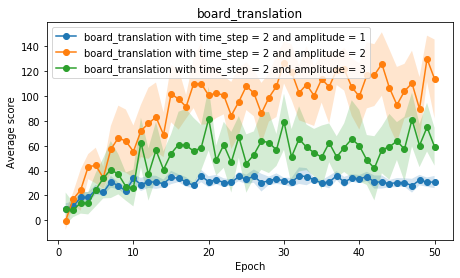

In [73]:
plot_params_variation(name = 'board_translation', params_fct=[[2,1],[2,2],[2,3]], nb_avg=10, epoch=50,
                      freq_video=10, transform_board=board_translation, lr=0.001, max_time=500, memory_size=5000, memory_access='linear')

In [35]:
nb_avg=10
epoch=50

scores_avg = np.zeros((nb_avg,epoch))
for i in range(nb_avg):
    agent = DQN_CNN(lr=.001, epsilon=0.3, memory_size=5000, batch_size=50, n_state=3)
    scores = train(agent, mod_env, epoch, freq_video=10, eps_decay=0.5, eps_step=3, 
                   prefix='{}_env'.format(name), memory_access=memory_access)
    scores = [scores[0]] + [scores[i]-scores[i-1] for i in range(len(scores)-1,0,-1)][::-1]
    scores_avg[i] += np.array(scores)

scores_mean = np.mean(scores_avg, axis=0)
scores_std = np.std(scores_avg, axis=0)
        
plt.plot(np.arange(1,epoch+1,1), scores_mean, marker='o', color='blue',
         label='Standard CNN DQN')
ub = scores_mean - 1.96*scores_std/np.sqrt(nb_avg)
lb = scores_mean + 1.96*scores_std/np.sqrt(nb_avg)
plt.fill_between(np.arange(1,epoch+1,1), ub, lb, color='blue', alpha=.2)
plt.legend()

1

### I - Modify the environment itself

#### 1 - Translation

In [15]:
def board_translation(infos, time_step=2, amplitude=1):
    """Translate the board
    
    input :
    -----
        infos : parser
            An object containing informations about the environment (it is the self object from the class)
        time_step : int
            Frequency at which we want to modify the board.
        amplitude : int
            Number of columns (or rows, it doesn't matter given the symmetry of the game) to consider
            to shift the board.
            
    output :
    ------
        a new version of the board contained in the object self
    """
    board = infos.board[4:-4,4:-4]
    malus_position = infos.malus_position[4:-4,4:-4]
    if infos.t%time_step==0: # done after self.t += 1 so the case t=0 doesn't need to be considered
        # for instance with an amplitude of 2 : board[:, 2:] = board[:, :-2] | board[:, :2] = board[:, -2:]
        board[:, amplitude:], board[:, :amplitude] = board[:, :-amplitude], board[:, -amplitude:]
        malus_position[:, amplitude:], malus_position[:, :amplitude] = malus_position[:, :-amplitude], malus_position[:, -amplitude:]
    
    final_board = np.zeros(infos.board.shape)
    final_malus_position = np.zeros(infos.malus_position.shape)
    final_board[4:-4,4:-4] = board
    final_malus_position[4:-4,4:-4] = malus_position
    return final_board, final_malus_position

In [634]:
K.clear_session()
##################################
epoch = 10
name = 'translate'
transform_fct = board_translation
##################################
mod_env = Adaptive_Environment(grid_size=size, max_time=500, temperature=0.3, immob_penalty=0.1,
                               transform_board=transform_fct)
agent = DQN_CNN(lr=.001, epsilon=0.3, memory_size=2000, batch_size=32, n_state=3)
train(agent, mod_env, epoch=epoch, eps_decay=0.5, eps_step=3, freq_video=1, prefix='{}_env'.format(name))
HTML(display_videos('{}_env_explore_{}.mp4'.format(name, epoch)))

Epoch 001/010 | Loss 0.0505 | Win/lose count 36.5(-3650.0%)/30.0(-3000.0%) (6.5)
Epoch 002/010 | Loss 0.0130 | Win/lose count 38.5(-3850.0%)/34.0(-3400.0%) (4.5)
Epoch 003/010 | Loss 0.0499 | Win/lose count 45.5(-4550.0%)/34.0(-3400.0%) (11.5)
Epoch 004/010 | Loss 0.1040 | Win/lose count 41.0(-4100.0%)/16.0(-1600.0%) (25.0)
Epoch 005/010 | Loss 0.0487 | Win/lose count 68.0(-6800.0%)/29.0(-2900.0%) (39.0)
Epoch 006/010 | Loss 0.0392 | Win/lose count 49.0(-4900.0%)/27.0(-2700.0%) (22.0)
Epoch 007/010 | Loss 0.1219 | Win/lose count 47.0(-4700.0%)/15.0(-1500.0%) (32.0)
Epoch 008/010 | Loss 0.1000 | Win/lose count 46.0(-4600.0%)/16.0(-1600.0%) (30.0)
Epoch 009/010 | Loss 0.0536 | Win/lose count 48.0(-4800.0%)/28.0(-2800.0%) (20.0)
Epoch 010/010 | Loss 0.1553 | Win/lose count 46.5(-4650.0%)/6.0(-600.0%) (40.5)


#### 2 - Random Flip

In [30]:
def board_flip(infos, time_step=10):
    """Translate the board
    
    input :
    -----
        infos : parser
            An object containing informations about the environment (it is the self object from the class)
        time_step : int
            Frequency at which we want to modify the board.
        amplitude : int
            Number of columns (or rows, it doesn't matter given the symmetry of the game) to consider
            to shift the board.
            
    output :
    ------
        a new version of the board contained in the object self
    """
    board = infos.board
    malus_position = infos.malus_position
    if infos.t%time_step==0: # done after self.t += 1 so the case t=0 doesn't need to be considered
        board = board[:, ::-1]
        malus_position = malus_position[:, ::-1]
    return board, malus_position

In [56]:
K.clear_session()
##################################
epoch = 10
name = 'flip'
transform_fct = board_flip
##################################
mod_env = Adaptive_Environment(grid_size=size, max_time=500, temperature=0.3, immob_penalty=0.1,
                               transform_board=transform_fct)
agent = DQN_CNN(lr=.001, epsilon=0.3, memory_size=2000, batch_size=32, n_state=3)
train(agent, mod_env, epoch=epoch, eps_decay=0.5, eps_step=3, freq_video=1, prefix='{}_env'.format(name))
HTML(display_videos('{}_env_explore_{}.mp4'.format(name, epoch)))

Epoch 001/010 | Loss 0.0844 | Win/lose count 39.5(69.9%)/31.0(40.8%) (8.5)
Epoch 002/010 | Loss 0.0423 | Win/lose count 47.5(83.3%)/19.0(26.4%) (28.5)
Epoch 003/010 | Loss 0.0360 | Win/lose count 49.0(94.2%)/36.0(40.9%) (13.0)
Epoch 004/010 | Loss 0.0291 | Win/lose count 57.0(97.4%)/25.0(28.1%) (32.0)
Epoch 005/010 | Loss 0.1260 | Win/lose count 49.5(95.2%)/26.0(36.1%) (23.5)
Epoch 006/010 | Loss 0.0835 | Win/lose count 45.5(94.8%)/18.0(26.5%) (27.5)
Epoch 007/010 | Loss 0.0417 | Win/lose count 42.5(91.4%)/13.0(18.8%) (29.5)
Epoch 008/010 | Loss 0.0490 | Win/lose count 53.5(93.0%)/21.0(26.6%) (32.5)
Epoch 009/010 | Loss 0.0790 | Win/lose count 59.5(96.7%)/16.0(23.5%) (43.5)
Epoch 010/010 | Loss 0.1540 | Win/lose count 44.0(91.7%)/19.0(22.6%) (25.0)


In the case of time_step $\neq 1$ is the approach using batches selected randomly in the memory relevant ? I don't think so but then how should we modify it ?

#### 3 - Reset the board

In [39]:
def board_reset(infos, time_step=10):
    """Translate the board
    
    input :
    -----
        infos : parser
            An object containing informations about the environment (it is the self object from the class)
        time_step : int
            Frequency at which we want to modify the board.
        amplitude : int
            Number of columns (or rows, it doesn't matter given the symmetry of the game) to consider
            to shift the board.
            
    output :
    ------
        a new version of the board contained in the object self
    """
    if infos.t%time_step==0: # done after self.t += 1 so the case t=0 doesn't need to be considered
        malus_position = np.zeros((infos.grid_size, infos.grid_size))

        bonus = 0.5*np.random.binomial(1, infos.temperature, size=infos.grid_size**2)
        bonus = bonus.reshape(infos.grid_size, infos.grid_size)

        malus = -1.0*np.random.binomial(1, infos.temperature, size=infos.grid_size**2)
        malus = malus.reshape(infos.grid_size, infos.grid_size)

        malus[bonus>0] = 0

        board = bonus + malus
    else:
        board = infos.board
        malus_position = infos.malus_position
    return board, malus_position

In [58]:
K.clear_session()
##################################
epoch = 10
name = 'reset'
transform_fct = board_reset
##################################
mod_env = Adaptive_Environment(grid_size=size, max_time=500, temperature=0.3, immob_penalty=0.1,
                               transform_board=transform_fct)
agent = DQN_CNN(lr=.001, epsilon=0.3, memory_size=2000, batch_size=32, n_state=3)
train(agent, mod_env, epoch=epoch, eps_decay=0.5, eps_step=3, freq_video=1, prefix='{}_env'.format(name))
HTML(display_videos('{}_env_explore_{}.mp4'.format(name, epoch)))

Epoch 001/010 | Loss 0.5215 | Win/lose count 78.0(173.3%)/41.0(48.2%) (37.0)
Epoch 002/010 | Loss 0.8198 | Win/lose count 102.0(183.8%)/34.0(45.9%) (68.0)
Epoch 003/010 | Loss 1.1639 | Win/lose count 111.5(206.5%)/37.0(46.8%) (74.5)
Epoch 004/010 | Loss 1.4087 | Win/lose count 123.0(236.5%)/21.0(26.6%) (102.0)
Epoch 005/010 | Loss 0.3834 | Win/lose count 118.5(215.5%)/30.0(46.2%) (88.5)
Epoch 006/010 | Loss 1.0864 | Win/lose count 120.0(250.0%)/34.0(46.6%) (86.0)
Epoch 007/010 | Loss 1.0490 | Win/lose count 134.5(224.2%)/17.0(20.7%) (117.5)
Epoch 008/010 | Loss 1.0104 | Win/lose count 140.5(228.5%)/18.0(21.7%) (122.5)
Epoch 009/010 | Loss 1.1866 | Win/lose count 134.0(252.8%)/20.0(25.6%) (114.0)
Epoch 010/010 | Loss 1.1451 | Win/lose count 146.5(279.0%)/14.0(17.5%) (132.5)


**This last experiment is impressive !! 125.0+ | 11.0- it shows that the algorithm works impressively well at first and then struggle to find the final cheese. Here since the board is reset every 10 steps, the number of cheese is reset and the algorithm doesn't have to explore the whole board to get reward so it stays in place and eats every bonus in a certain global position. Great experiment !**

#### 3 (bis) - Reset the board (same initialisation)

In [44]:
def board_reinit(infos, time_step=10):
    """Translate the board
    
    input :
    -----
        infos : parser
            An object containing informations about the environment (it is the self object from the class)
        time_step : int
            Frequency at which we want to modify the board.
        amplitude : int
            Number of columns (or rows, it doesn't matter given the symmetry of the game) to consider
            to shift the board.
            
    output :
    ------
        a new version of the board contained in the object self
    """
    if infos.t%time_step==0: # done after self.t += 1 so the case t=0 doesn't need to be considered
        malus_position = np.zeros((infos.grid_size, infos.grid_size))

        bonus = np.where(infos.to_draw[0, ::infos.scale, ::infos.scale, 0]==256, 0.5, 0)
        malus = np.where(infos.to_draw[0, ::infos.scale, ::infos.scale, 2]==256, -1.0, 0)
        
        board = bonus + malus
        
        #init_loc = np.where(infos.to_draw[0, ::infos.scale, ::infos.scale]==[256,256,256])
        #board[init_loc[0],init_loc[1]] = 0 # The original location is originaly empty
    else:
        board = infos.board
        malus_position = infos.malus_position
    return board, malus_position

In [64]:
K.clear_session()
##################################
epoch = 10
name = 'reinit'
transform_fct = board_reinit
##################################
mod_env = Adaptive_Environment(grid_size=size, max_time=500, temperature=0.3, immob_penalty=0.1,
                               transform_board=transform_fct)
agent = DQN_CNN(lr=.001, epsilon=0.3, memory_size=2000, batch_size=32, n_state=3)
train(agent, mod_env, epoch=epoch, eps_decay=0.5, eps_step=3, freq_video=1, prefix='{}_env'.format(name))
HTML(display_videos('{}_env_explore_{}.mp4'.format(name, epoch)))

Epoch 001/010 | Loss 0.4499 | Win/lose count 57.0(122.6%)/42.5(47.2%) (14.5)
Epoch 002/010 | Loss 1.9951 | Win/lose count 126.0(235.5%)/25.0(28.7%) (101.0)
Epoch 003/010 | Loss 1.7212 | Win/lose count 128.5(238.0%)/29.0(38.2%) (99.5)
Epoch 004/010 | Loss 1.5059 | Win/lose count 160.5(276.7%)/14.0(16.1%) (146.5)
Epoch 005/010 | Loss 2.7496 | Win/lose count 166.0(276.7%)/10.5(14.4%) (155.5)
Epoch 006/010 | Loss 1.1482 | Win/lose count 148.5(258.3%)/14.0(20.9%) (134.5)
Epoch 007/010 | Loss 0.8411 | Win/lose count 122.0(271.1%)/9.5(12.7%) (112.5)
Epoch 008/010 | Loss 2.0947 | Win/lose count 174.5(352.5%)/5.0(6.2%) (169.5)
Epoch 009/010 | Loss 3.5004 | Win/lose count 194.5(350.5%)/6.0(8.6%) (188.5)
Epoch 010/010 | Loss 1.9558 | Win/lose count 166.0(338.8%)/5.0(6.4%) (161.0)


**4) Impact of the rat's actions : based on what the rat eats, his vision can increase/decrease in dimension**

In [64]:
def visibility_changed(infos,win,lose,win_freq=5,lose_freq=5):
    """Increases the visibility of the rat when it has eaten enough cheese
    
    input :
    -----
        infos : parser
            An object containing informations about the environment (it is the self object from the class)
        
            
    output :
    ------
        a new version of the visibility contained in the object self
    """
    vis = infos.vis
    
    if win%win_freq==0 and vis < 4 and win>0:
        vis = vis +1
    if lose%lose_freq==0 and vis>2 and lose>0 :
        vis = vis - 1
    return vis

In [62]:
K.clear_session()
##################################
epoch = 10
name = 'visibility_changed'
transform_fct = visibility_changed
##################################
mod_env = Adaptive_Environment(grid_size=size, max_time=500, temperature=0.3, immob_penalty=0.1,
                               transform_visibility=transform_fct)
agent = DQN_CNN(lr=.001, epsilon=0.3, memory_size=2000, batch_size=32, n_state=3)
train(agent, mod_env, epoch=epoch, eps_decay=0.5, eps_step=3, freq_video=1, prefix='{}_env'.format(name))
HTML(display_videos('{}_env_explore_{}.mp4'.format(name, epoch)))

Epoch 001/010 | Loss 0.1124 | Win/lose count 39.0(78.8%)/26.0(33.8%) (13.0)
Epoch 002/010 | Loss 0.1150 | Win/lose count 26.5(49.1%)/18.0(20.7%) (8.5)
Epoch 003/010 | Loss 0.0232 | Win/lose count 52.5(95.5%)/29.0(39.7%) (23.5)
Epoch 004/010 | Loss 0.0407 | Win/lose count 51.5(93.6%)/17.0(25.4%) (34.5)
Epoch 005/010 | Loss 0.0510 | Win/lose count 46.5(88.6%)/12.0(15.0%) (34.5)
Epoch 006/010 | Loss 0.0624 | Win/lose count 46.5(94.9%)/8.0(11.3%) (38.5)
Epoch 007/010 | Loss 0.0545 | Win/lose count 56.0(98.2%)/11.0(13.1%) (45.0)
Epoch 008/010 | Loss 0.1315 | Win/lose count 39.5(82.3%)/9.0(11.8%) (30.5)
Epoch 009/010 | Loss 0.0347 | Win/lose count 52.5(96.3%)/10.0(13.3%) (42.5)
Epoch 010/010 | Loss 0.0467 | Win/lose count 53.5(98.2%)/6.0(8.3%) (47.5)


**5) Impact of the rat's actions : new rewards pop on the board based on the rat's actions**

In [529]:
def reward_changed(infos, win, value=2, freq = 10):
    """Increases the visibility of the rat when it has eaten enough cheese
    
    input :
    -----
        infos : parser
            An object containing informations about the environment (it is the self object from the class)
        
            
    output :
    ------
        a new version of the visibility contained in the object self
    """
    board = infos.board
    available_locations = np.where(infos.to_draw[0, ::infos.scale, ::infos.scale]==[128,128,128])
    available_locations = [(available_locations[0][index], available_locations[1][index]) \
                               for index in range(0,len(available_locations[0]),3)]
    if win%freq==0 and win>0:
        x_cheese, y_cheese = available_locations[np.random.randint(len(available_locations))]
        board[x_cheese, y_cheese] = value
    return board

In [68]:
K.clear_session()
##################################
epoch = 10
name = 'big_cheese_added'
transform_fct = reward_changed
##################################
mod_env = Adaptive_Environment(grid_size=size, max_time=500, temperature=0.3, immob_penalty=0.1,
                               add_reward=transform_fct)
agent = DQN_CNN(lr=.001, epsilon=0.3, memory_size=2000, batch_size=32, n_state=3)
train(agent, mod_env, epoch=epoch, eps_decay=0.5, eps_step=3, freq_video=1, prefix='{}_env'.format(name))
HTML(display_videos('{}_env_explore_{}.mp4'.format(name, epoch)))

Epoch 001/010 | Loss 0.4448 | Win/lose count 44.5(80.2%)/19.0(26.8%) (25.5)
Epoch 002/010 | Loss 0.0415 | Win/lose count 37.5(75.0%)/21.0(27.6%) (16.5)
Epoch 003/010 | Loss 0.0515 | Win/lose count 55.9(105.5%)/20.0(27.8%) (35.9)
Epoch 004/010 | Loss 0.0705 | Win/lose count 53.4(111.2%)/14.0(20.0%) (39.4)
Epoch 005/010 | Loss 0.0324 | Win/lose count 59.0(108.3%)/14.0(17.5%) (45.0)
Epoch 006/010 | Loss 0.0754 | Win/lose count 57.4(99.0%)/13.0(19.4%) (44.4)
Epoch 007/010 | Loss 0.0268 | Win/lose count 60.9(105.0%)/17.0(20.5%) (43.9)
Epoch 008/010 | Loss 0.0419 | Win/lose count 50.4(91.6%)/7.0(8.9%) (43.4)
Epoch 009/010 | Loss 0.1240 | Win/lose count 58.0(108.4%)/9.0(11.7%) (49.0)
Epoch 010/010 | Loss 0.0567 | Win/lose count 46.0(90.2%)/7.0(9.6%) (39.0)


### II - Probability distribution

In [69]:
def board_dist(infos, dist_type='gaussian'):
    """Translate the board
    
    input :
    -----
        infos : parser
            An object containing informations about the environment (it is the self object from the class)
        time_step : int
            Frequency at which we want to modify the board.
        amplitude : int
            Number of columns (or rows, it doesn't matter given the symmetry of the game) to consider
            to shift the board.
            
    output :
    ------
        a new version of the board contained in the object self
    """
    board = infos.board
    malus_position = infos.malus_position
    x = infos.x
    y = infos.y
    
    if board[x,y]==0.5:
        if dist_type=='gaussian':
            board[x,y] = np.random.normal(0.5,1.0)
        elif dist_type=='bernoulli':
            board[x,y] -= np.random.binomial(1,0.5) # turn it to -0.5 with proba 1/2
    elif board[x,y]==-1.0:
        if dist_type=='gaussian':
            board[x,y] = np.random.normal(-1.,0.5)
        elif dist_type=='bernoulli':
            board[x,y] += 0.5*np.random.binomial(1,0.5) # turn it to -0.5 with proba 1/2
    
    ### Should we consider the malus_position as being a random variable as well ?
    #malus_position = infos.malus_position
    return board, malus_position

In [70]:
K.clear_session()
##################################
epoch = 10
name = 'prob_dist'
transform_fct = board_dist
##################################
mod_env = Adaptive_Environment(grid_size=size, max_time=500, temperature=0.3, immob_penalty=0.1,
                               transform_board=transform_fct)
agent = DQN_CNN(lr=.001, epsilon=0.3, memory_size=2000, batch_size=32, n_state=3)
train(agent, mod_env, epoch=epoch, eps_decay=0.5, eps_step=3, freq_video=1, prefix='{}_env'.format(name))
HTML(display_videos('{}_env_explore_{}.mp4'.format(name, epoch)))

Epoch 001/010 | Loss 4.1807 | Win/lose count 38.23054698378583(76.5%)/33.3254971188238(41.1%) (4.9)
Epoch 002/010 | Loss 0.2646 | Win/lose count 41.88107809696775(79.0%)/30.547884801438332(37.7%) (11.3)
Epoch 003/010 | Loss 0.0540 | Win/lose count 61.934313844752886(110.6%)/37.03207817176561(50.0%) (24.9)
Epoch 004/010 | Loss 0.1211 | Win/lose count 41.501478316537685(82.2%)/29.282708422816384(35.3%) (12.2)
Epoch 005/010 | Loss 1.7989 | Win/lose count 47.78407499312591(87.7%)/24.237999864322653(35.1%) (23.5)
Epoch 006/010 | Loss 0.0395 | Win/lose count 60.06420774013503(108.2%)/40.709964703892936(49.6%) (19.4)
Epoch 007/010 | Loss 0.1360 | Win/lose count 40.628624686244095(73.2%)/29.291573606202576(41.8%) (11.3)
Epoch 008/010 | Loss 0.2909 | Win/lose count 41.55975171705669(78.4%)/34.00078156504722(44.7%) (7.6)
Epoch 009/010 | Loss 0.1339 | Win/lose count 49.136857111836036(92.7%)/23.111096341247013(34.5%) (26.0)
Epoch 010/010 | Loss 0.0676 | Win/lose count 30.373651358208395(54.7%)/32

In [128]:
class UCB_CNN(DQN_CNN):
    def __init__(self, *args, alpha=0.5, **kwargs):
        super(UCB_CNN, self).__init__(*args, **kwargs)
        
        self.alpha = alpha
        self.K = 4 # Number of actions : [action giving the worst reward, action giving the 2nd worst reward...]
        self.occurence = np.ones((self.K))
        
    def learned_act(self, s):
        # When we call learned act in the `act` function, we want to apply the same process as in UCB :
        # Select the action as the argmax(estim_mean_reward + sqrt(alpha*ln(t)/(2*N)))
        # considering each arm as being 'sorted' : arm 1 is the best known reward, arm 2 the second...
        if self.t==1: # Reset the weights at each epoch
            self.occurence = np.ones((self.K))
        pred_rwd_per_action = self.model.predict(s.reshape(1,9,9,self.n_state)).reshape(-1,)
        map_actions = np.argsort(pred_rwd_per_action) # -> first element (=i) says that action i has the lowest score
        ucb_rewards = np.sort(pred_rwd_per_action) + np.sqrt(self.alpha*np.log(self.t)/(2*self.occurence))
        ucb_action = np.argmax(ucb_rewards)
        self.occurence[ucb_action] += 1
        true_action = map_actions[ucb_action]
        return true_action

In [106]:
K.clear_session()
##################################
epoch = 10
name = 'prob_dist'
transform_fct = board_dist
##################################
mod_env = Adaptive_Environment(grid_size=size, max_time=500, temperature=0.3, immob_penalty=0.1,
                               transform_board=transform_fct)
agent = UCB_CNN(lr=.001, epsilon=0.3, memory_size=2000, batch_size=32, n_state=3)
train(agent, mod_env, epoch=epoch, eps_decay=0.5, eps_step=3, freq_video=1, prefix='{}_env'.format(name))
HTML(display_videos('{}_env_explore_{}.mp4'.format(name, epoch)))

Epoch 001/010 | Loss 0.2639 | Win/lose count 52.866175234158305(96.1%)/37.52713206589773(63.6%) (15.3)
Epoch 002/010 | Loss 0.1314 | Win/lose count 53.92124128990279(94.6%)/37.18717460578776(54.7%) (16.7)
Epoch 003/010 | Loss 1.1645 | Win/lose count 42.49629110132316(75.9%)/36.16306085092378(55.6%) (6.3)
Epoch 004/010 | Loss 0.2516 | Win/lose count 64.90915309580595(126.0%)/35.4988350593202(40.8%) (29.4)
Epoch 005/010 | Loss 0.4385 | Win/lose count 42.51216557880599(86.8%)/35.1211503572103(49.5%) (7.4)
Epoch 006/010 | Loss 0.0230 | Win/lose count 34.720301319343484(73.9%)/27.368848737476636(34.2%) (7.4)
Epoch 007/010 | Loss 0.3658 | Win/lose count 47.24213226074278(102.7%)/29.889418632825304(38.8%) (17.4)
Epoch 008/010 | Loss 0.0382 | Win/lose count 42.55830870553849(82.6%)/27.258377558410874(32.5%) (15.3)
Epoch 009/010 | Loss 0.0696 | Win/lose count 33.97167291493281(61.2%)/23.71620983561219(30.4%) (10.3)
Epoch 010/010 | Loss 0.0519 | Win/lose count 39.06116248823437(76.6%)/29.9479922

### III - Adversarial

In [116]:
def board_adv(infos, time_step=10):
    """Translate the board
    
    input :
    -----
        infos : parser
            An object containing informations about the environment (it is the self object from the class)
        time_step : int
            Frequency at which we want to modify the board.
        amplitude : int
            Number of columns (or rows, it doesn't matter given the symmetry of the game) to consider
            to shift the board.
            
    output :
    ------
        a new version of the board contained in the object self
    """
    malus_position = infos.malus_position
    if infos.t%time_step==0: # done after self.t += 1 so the case t=0 doesn't need to be considered
        board = - infos.board
    else:
        board = infos.board
    return board, malus_position

In [72]:
K.clear_session()
##################################
epoch = 10
name = 'adverse'
transform_fct = board_adv
##################################
mod_env = Adaptive_Environment(grid_size=size, max_time=500, temperature=0.3, immob_penalty=0.1,
                               transform_board=transform_fct)
agent = DQN_CNN(lr=.001, epsilon=0.3, memory_size=2000, batch_size=32, n_state=3)
train(agent, mod_env, epoch=epoch, eps_decay=0.5, eps_step=3, freq_video=1, prefix='{}_env'.format(name))
HTML(display_videos('{}_env_explore_{}.mp4'.format(name, epoch)))

Epoch 001/010 | Loss 0.1181 | Win/lose count 52.0(86.0%)/23.0(37.1%) (29.0)
Epoch 002/010 | Loss 0.4107 | Win/lose count 67.0(127.6%)/22.0(28.2%) (45.0)
Epoch 003/010 | Loss 0.0631 | Win/lose count 81.0(138.5%)/22.5(31.7%) (58.5)
Epoch 004/010 | Loss 0.0654 | Win/lose count 68.0(140.2%)/19.5(26.0%) (48.5)
Epoch 005/010 | Loss 0.4854 | Win/lose count 73.5(130.1%)/23.0(34.8%) (50.5)
Epoch 006/010 | Loss 0.0276 | Win/lose count 80.0(146.8%)/22.0(32.4%) (58.0)
Epoch 007/010 | Loss 0.0368 | Win/lose count 71.5(147.4%)/15.0(18.8%) (56.5)
Epoch 008/010 | Loss 0.0570 | Win/lose count 93.0(189.8%)/19.5(20.7%) (73.5)
Epoch 009/010 | Loss 0.7633 | Win/lose count 96.0(177.8%)/16.5(21.4%) (79.5)
Epoch 010/010 | Loss 0.7330 | Win/lose count 81.0(157.3%)/16.5(22.6%) (64.5)


In [127]:
class adverse_CNN(DQN_CNN):
    def __init__(self, *args, gamma=.5, **kwargs):
        super(adverse_CNN, self).__init__(*args, **kwargs)
        
        self.gamma = gamma
        self.K = 4 # Number of actions : [action giving the worst reward, action giving the 2nd worst reward...]
        self.weights = np.ones((self.K))
        
    def learned_act(self, s):
        # When we call learned act in the `act` function, we want to apply the same process as in Exp3 :
        # - for each arm i, set p[i] = (1-gamma) * (w[i]/np.sum(w)) + gamma / K
        # - select the action using action = np.argmax(np.random.multinomial(1,p))
        # - predict the corresponding reward = self.model.predict(s.reshape(1,9,9,self.n_state))[action]
        # - compute the estimated_reward = reward / p[action]
        # - update the weights : weights[action] *= np.exp(gamma * estimated_reward / K)
        if self.t==1: # Reset the weights at each epoch
            self.weights = np.ones((self.K))
        pred_rwd_per_action = self.model.predict(s.reshape(1,9,9,self.n_state)).reshape(-1,)
        prob = (1-self.gamma) * (self.weights/np.sum(self.weights)) + self.gamma / self.K
        map_actions = np.argsort(pred_rwd_per_action) # -> first element (=i) says that action i has the lowest score
        action_to_take = np.argmax(np.random.multinomial(1,prob))
        # This gives which ordered action to take : the one giving the lowest reward, the 2nd, etc...
        true_action = map_actions[action_to_take] # says that this is the action n°2 for instance
        est_adv_rewards = pred_rwd_per_action[true_action] / prob[action_to_take]
        self.weights[action_to_take] *= np.exp(self.gamma * est_adv_rewards / self.K)
        return true_action

In [110]:
K.clear_session()
##################################
epoch = 10
name = 'adverse'
transform_fct = board_adv
##################################
mod_env = Adaptive_Environment(grid_size=size, max_time=500, temperature=0.3, immob_penalty=0.1,
                               transform_board=transform_fct)
agent = adverse_CNN(lr=.001, epsilon=0.3, memory_size=2000, batch_size=32, n_state=3)
train(agent, mod_env, epoch=epoch, eps_decay=0.5, eps_step=3, freq_video=1, prefix='{}_env'.format(name))
HTML(display_videos('{}_env_explore_{}.mp4'.format(name, epoch)))

Epoch 001/010 | Loss 0.6044 | Win/lose count 29.5(59.0%)/15.5(20.7%) (14.0)
Epoch 002/010 | Loss 1.0270 | Win/lose count 56.5(100.9%)/28.5(37.0%) (28.0)
Epoch 003/010 | Loss 0.5902 | Win/lose count 31.5(59.4%)/28.5(40.7%) (3.0)
Epoch 004/010 | Loss 0.0540 | Win/lose count 53.0(108.2%)/18.0(23.4%) (35.0)
Epoch 005/010 | Loss 0.8809 | Win/lose count 46.0(98.9%)/19.0(23.8%) (27.0)
Epoch 006/010 | Loss 0.8141 | Win/lose count 63.5(122.1%)/15.0(21.1%) (48.5)
Epoch 007/010 | Loss 0.3216 | Win/lose count 62.0(120.4%)/28.0(38.4%) (34.0)
Epoch 008/010 | Loss 0.0759 | Win/lose count 64.0(114.3%)/13.5(18.5%) (50.5)
Epoch 009/010 | Loss 0.7337 | Win/lose count 73.0(141.7%)/23.0(27.4%) (50.0)
Epoch 010/010 | Loss 2.1830 | Win/lose count 55.5(103.7%)/23.0(28.8%) (32.5)


Epoch 001/050 | Loss 0.0020 | Win/lose count 17.5(41.7%)/16.0(19.5%) (1.5)
Epoch 002/050 | Loss 0.0820 | Win/lose count 37.0(64.9%)/28.0(33.7%) (9.0)
Epoch 003/050 | Loss 0.0730 | Win/lose count 47.5(80.5%)/27.5(41.0%) (20.0)
Epoch 004/050 | Loss 0.0630 | Win/lose count 26.0(48.6%)/17.5(22.7%) (8.5)
Epoch 005/050 | Loss 0.0639 | Win/lose count 42.5(81.0%)/20.5(24.7%) (22.0)
Epoch 006/050 | Loss 0.0790 | Win/lose count 52.5(94.6%)/18.0(21.2%) (34.5)
Epoch 007/050 | Loss 0.1816 | Win/lose count 55.0(102.8%)/19.5(27.1%) (35.5)
Epoch 008/050 | Loss 0.2846 | Win/lose count 69.5(127.5%)/18.5(21.0%) (51.0)
Epoch 009/050 | Loss 0.1790 | Win/lose count 80.5(169.5%)/17.5(18.8%) (63.0)
Epoch 010/050 | Loss 0.4745 | Win/lose count 73.0(125.9%)/19.5(26.4%) (53.5)
Epoch 011/050 | Loss 0.4145 | Win/lose count 53.0(112.8%)/17.5(19.0%) (35.5)
Epoch 012/050 | Loss 0.7930 | Win/lose count 82.0(143.9%)/23.5(32.2%) (58.5)
Epoch 013/050 | Loss 0.4026 | Win/lose count 82.0(164.0%)/18.5(22.0%) (63.5)
Epoch 01

Epoch 008/050 | Loss 0.2915 | Win/lose count 75.0(151.5%)/16.0(19.8%) (59.0)
Epoch 009/050 | Loss 0.2544 | Win/lose count 76.5(157.7%)/22.0(26.2%) (54.5)
Epoch 010/050 | Loss 0.4329 | Win/lose count 56.5(102.7%)/19.5(28.3%) (37.0)
Epoch 011/050 | Loss 0.3152 | Win/lose count 92.0(154.6%)/19.5(25.3%) (72.5)
Epoch 012/050 | Loss 0.2572 | Win/lose count 64.0(121.9%)/21.0(30.0%) (43.0)
Epoch 013/050 | Loss 0.0633 | Win/lose count 79.5(155.9%)/16.0(18.6%) (63.5)
Epoch 014/050 | Loss 0.2845 | Win/lose count 71.5(140.2%)/23.5(31.3%) (48.0)
Epoch 015/050 | Loss 0.5444 | Win/lose count 85.5(143.7%)/20.5(33.6%) (65.0)
Epoch 016/050 | Loss 0.8055 | Win/lose count 71.5(128.8%)/32.5(41.1%) (39.0)
Epoch 017/050 | Loss 0.6361 | Win/lose count 80.0(118.5%)/20.0(29.9%) (60.0)
Epoch 018/050 | Loss 0.4017 | Win/lose count 77.5(128.1%)/22.0(35.5%) (55.5)
Epoch 019/050 | Loss 0.2941 | Win/lose count 91.0(175.0%)/22.0(26.5%) (69.0)
Epoch 020/050 | Loss 0.2528 | Win/lose count 96.5(173.9%)/22.5(27.4%) (74.0)

Epoch 015/050 | Loss 0.6336 | Win/lose count 69.5(156.2%)/18.0(19.6%) (51.5)
Epoch 016/050 | Loss 0.4206 | Win/lose count 76.5(151.5%)/18.0(20.2%) (58.5)
Epoch 017/050 | Loss 0.0339 | Win/lose count 58.5(117.0%)/14.5(18.8%) (44.0)
Epoch 018/050 | Loss 0.0796 | Win/lose count 51.5(113.2%)/12.0(16.4%) (39.5)
Epoch 019/050 | Loss 0.3036 | Win/lose count 69.5(120.9%)/14.0(22.2%) (55.5)
Epoch 020/050 | Loss 0.6249 | Win/lose count 60.5(104.3%)/28.0(41.2%) (32.5)
Epoch 021/050 | Loss 0.1568 | Win/lose count 82.5(171.9%)/24.0(30.8%) (58.5)
Epoch 022/050 | Loss 0.1006 | Win/lose count 73.0(123.7%)/20.0(30.8%) (53.0)
Epoch 023/050 | Loss 0.3144 | Win/lose count 75.5(151.0%)/23.5(29.4%) (52.0)
Epoch 024/050 | Loss 0.5170 | Win/lose count 68.5(128.0%)/15.0(23.4%) (53.5)
Epoch 025/050 | Loss 0.4918 | Win/lose count 57.5(101.8%)/22.0(28.9%) (35.5)
Epoch 026/050 | Loss 0.0514 | Win/lose count 64.0(119.6%)/21.5(29.1%) (42.5)
Epoch 027/050 | Loss 0.0611 | Win/lose count 79.0(154.9%)/21.5(23.1%) (57.5)

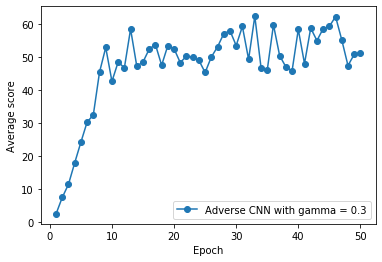

In [143]:
K.clear_session()
##################################
epoch = 50
name = 'adverse_CNN'
transform_fct = board_adv
##################################
mod_env = Adaptive_Environment(grid_size=size, max_time=500, temperature=0.3, immob_penalty=0.1,
                               transform_board=transform_fct)
#agent = adverse_CNN(gamma=0.3, lr=.001, epsilon=0.3, memory_size=2000, batch_size=32, n_state=3)
#train(agent, mod_env, epoch=epoch, eps_decay=0.5, eps_step=3, freq_video=1, prefix='{}_env'.format(name))
#HTML(display_videos('{}_env_explore_{}.mp4'.format(name, epoch)))

scores_avg = np.zeros(epoch)
nb_avg = 5
for i in range(nb_avg):
    agent = adverse_CNN(gamma=0.3, lr=.00001, epsilon=0, memory_size=5000, batch_size=32, n_state=3)
    scores = train(agent, mod_env, epoch, freq_video=10,
                   prefix='{}_env'.format(name))
    scores = [scores[0]] + [scores[i]-scores[i-1] for i in range(len(scores)-1,0,-1)][::-1]
    scores_avg += np.array(scores)

scores_avg = scores_avg/nb_avg

plt.plot(np.arange(1,epoch+1,1),scores_avg, marker='o',
         label='Adverse CNN with gamma = 0.3')

plt.xlabel('Epoch')
plt.ylabel('Average score')
plt.legend()
plt.show()